## Polsky Center Cost Analysis 

The goal of this notebook is to determine an average cost for patenting an invention, the average assocaited revenue for a licensed invention, and to develop metrics related to net benefits steming from optimized models 

### 1. Load packages and datasets 

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import missingno as msno
import plotly.graph_objects as go
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)

In [138]:
# Agreement Dataset 
df_ag_full = pd.DataFrame(pd.read_csv("Agreement_cleaned.csv"))
print("Agreement Shape:", df_ag_full.shape)

# Technology Dataset 
df_exp = pd.DataFrame(pd.read_csv("patentExpenses.csv"))
print("Patent Expenses Shape:", df_exp.shape)

# Current Receivables Dataset 
df_fin = pd.DataFrame(pd.read_csv("Current_Receivables.csv"))
print("Receivables Shape:", df_fin.shape)

# Incorporate 2012 Patents dataset for cost comparisions 
pat_2012 = pd.DataFrame(pd.read_csv("patent_dataset_2012.csv"))
print("2012 Patents Shape:", pat_2012.shape)

Agreement Shape: (3843, 23)
Patent Expenses Shape: (59921, 8)
Receivables Shape: (578, 22)
2012 Patents Shape: (1190, 41)


In [139]:
pat_2012.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 41 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Unnamed: 0                                        1190 non-null   int64  
 1   Disclosure_Date                                   1190 non-null   object 
 2   Country_WIPO_ID                                   1190 non-null   object 
 3   Tech_ID                                           1190 non-null   object 
 4   Actually_File_Date                                1190 non-null   object 
 5   Is_Priority                                       1190 non-null   object 
 6   Lawfirm                                           1190 non-null   object 
 7   Attorney                                          1190 non-null   object 
 8   Number_of_Inventors                               1190 non-null   float64
 9   Application_Type   

### 2. Data Cleaning 

#### 2.1 Agreements Dataset

In [140]:
# Include copies of Agreement dataset to be used for merge analysis
df_ag_check = df_ag_full[['Agreement_ID', 'Status']].copy()
df_ag = df_ag_full.copy()

In [141]:
df_ag.nunique()

Unnamed: 0               3843
Agreement_ID             3843
Parties                  2036
Agreement_Type             43
Manager                    13
Responsible_Manager         6
Title                    3559
Number_of_Parties          11
In_or_Out                   2
Reference_Number         1821
Status                     10
Status_Date              1235
Effective_Date           2094
Agreement_Term             27
Term_Date                1565
Sign_Date                1173
Field_Of_Use             1680
Equity                      2
Reimbursable_Expenses       2
Technologies             1032
Division_Department       191
Investigators             985
Last_Related_Update      3343
dtype: int64

In [142]:
#  Remove the S indicators at the end of Agreement_IDs, these are sub-agreements under the same revenue-generating agreement
df_ag['Agreement_ID'] = df_ag['Agreement_ID'].str.split('.').str[0]

# We will adjust the dataset so we have one unique Tech_ID and Agreement_ID per row 
df_ag = df_ag.assign(Tech_ID=df_ag['Technologies'].str.split(',')).explode('Tech_ID')

# We are *only* looking for Active Agreements 
df_ag = df_ag.loc[df_ag['Status'] == 'Active'] 

# Remove any duplicate Agreement_ID/Tech_ID combinations, and confirm we only have unique combos 
df_ag = df_ag.groupby(['Agreement_ID','Tech_ID'])
df_ag = df_ag.first().reset_index()

# Confirm there are no duplicates in the dataset 
duplicates = df_ag[df_ag.duplicated(subset=['Agreement_ID','Tech_ID'], keep=False)]
duplicates.shape

(0, 24)

In [143]:
# Review unique Technologies, Agreements, and combinations 
print("Count of unique techologies with an active licensing agreement:", df_ag['Tech_ID'].nunique())

print("Count of unique active licensing agreements:", df_ag['Agreement_ID'].nunique())

print("Count of unique technology/active license combinations:", df_ag.shape)

Count of unique techologies with an active licensing agreement: 644
Count of unique active licensing agreements: 455
Count of unique technology/active license combinations: (937, 24)


#### 2.2 Receivables Dataset

In [144]:
# There are 117 agreements with associated receivables data
df_fin.nunique()

Agreement ID                     117
Category                           3
Receivable Status                  1
Comments                          20
Party Name                       104
Attn                               4
Agreement Manager                  5
Agreement Responsible Manager      3
Invoice Number                   358
Party Balance Remaining          360
Party Amount Due                 357
Party Paid to Date                18
Total Revenue                    102
Total Reimbursable Expense       260
PO Number                        172
Invoice Date                     239
Party Last Paid Date              16
Due Date                         243
Payment Term                       1
Last Printed Date                  1
Type                               3
Archive Date                       1
dtype: int64

In [145]:
#reanme Agreement_ID prior to merge 
df_fin = df_fin.rename(columns={'Agreement ID': 'Agreement_ID'})

# Select columns of interest 
df_fin = df_fin[['Agreement_ID', 'Category', 'Party Amount Due']].copy()

# We are *only* looking for receivables with a status of "reimbursement"
df_fin = df_fin.loc[df_fin['Category'] == 'Reimbursement'] 

# Get total amount due for unique agreements 
df_fin['party_amount_due'] = df_fin['Party Amount Due'].groupby(df_fin['Agreement_ID']).transform('sum')

# Remove any duplicate Agreement_ID/Total Amount combinations, and confirm we only have unique combos 
df_fin = df_fin.groupby(['Agreement_ID','party_amount_due'])
df_fin = df_fin.first().reset_index()

# Drop Party Amount Due and Category 
df_fin.drop('Party Amount Due', axis=1, inplace=True)
df_fin.drop('Category', axis=1, inplace=True)

# Confirm there are no duplicates in the dataset 
duplicates = df_fin[df_fin.duplicated(subset=['Agreement_ID'], keep=False)]
duplicates.shape

(0, 2)

In [146]:
print("Count of unique active licensing agreements:", df_fin['Agreement_ID'].nunique())

Count of unique active licensing agreements: 81


#### 2.3 Patent Expenses Shape 

In [147]:
# 1243 unique Technologies in the dataset 
df_exp.nunique()

Tech ID            1243
Internal ID        5082
Expense Amount    26709
Patent Number      1357
Serial Number      5013
Expense Type         17
Srvc Date          1860
Country              88
dtype: int64

In [148]:
#reanme Agreement_ID prior to merge 
df_exp = df_exp.rename(columns={'Tech ID': 'Tech_ID'})

In [149]:
# Get total amount due for unique agreements 
df_exp['expense_amount'] = df_exp['Expense Amount'].groupby(df_exp['Tech_ID']).transform('sum')

# Remove any duplicate Agreement_ID/Total Amount combinations, and confirm we only have unique combos 
df_exp = df_exp.groupby(['Tech_ID','expense_amount'])
df_exp = df_exp.first().reset_index()

# Drop Party Amount Due and Category 
df_exp.drop('Internal ID', axis=1, inplace=True)
df_exp.drop('Expense Amount', axis=1, inplace=True)
df_exp.drop('Patent Number', axis=1, inplace=True)
df_exp.drop('Serial Number', axis=1, inplace=True)
df_exp.drop('Expense Type', axis=1, inplace=True)
df_exp.drop('Srvc Date', axis=1, inplace=True)
df_exp.drop('Country', axis=1, inplace=True)

# Confirm there are no duplicates in the dataset 
duplicates = df_exp[df_exp.duplicated(subset=['Tech_ID'], keep=False)]
duplicates.shape

(0, 2)

In [150]:
print("Count of unique technologies with patent expenses:", df_exp['Tech_ID'].nunique())

Count of unique technologies with patent expenses: 1243


### 3 Merge Datasets

In [151]:
# Merge Agreements Dataset with patent expense dataset 
merge1 = df_ag.merge(df_exp.drop_duplicates(), on=['Tech_ID'], 
                   how='inner', indicator=False)

len(merge1)

321

In [152]:
# Merge Agreements Dataset with patent expense dataset 
df_pat_cost = merge1.merge(df_fin.drop_duplicates(), on=['Agreement_ID'], 
                   how='left', indicator=False)

len(df_pat_cost)

321

### Extract Cost Values 

In [153]:
df_pat_cost['party_amount_due'] = df_pat_cost['party_amount_due'].fillna(0)

df_pat_cost['total_patenting_cost'] = df_pat_cost['party_amount_due'] + df_pat_cost['expense_amount']

In [154]:
df_pat_cost.head(15)

,Agreement_ID,Tech_ID,Unnamed: 0,Parties,Agreement_Type,Manager,Responsible_Manager,Title,Number_of_Parties,In_or_Out,...,Field_Of_Use,Equity,Reimbursable_Expenses,Technologies,Division_Department,Investigators,Last_Related_Update,expense_amount,party_amount_due,total_patenting_cost
0,01-A-029,00-T-008,70,"Hologic, Inc. (fka R2 Technology)",Non-Exclusive License - All Fields,"Juggernauth, Anne","Stocco, Teana","R2 Technology, Inc. Non-Exclusive w/ Equity 2001",1,Out,...,Computer-aided diagnosis of diseases and/or di...,Yes,Yes,"00-T-008, 00-T-010, 00-T-060, 01-T-008, 01-T-0...","Biological Sciences Division (BSD), Comprehens...","Yali Amit, Masahito Aoyama, Samuel Armato, Ulr...",2022-01-26 09:23:36,37198.62,0.0,37198.62
1,02-A-024,01-T-020,101,Dana-Farber Cancer Institute (DFCI),Interinstitutional Agreement (IIA),"Tennant, Thelma","Stocco, Teana","Dana Farber Cancer Institute, IIA, 2002 (Weich...",1,Out,...,All - UChicago leads; part of a larger IIA fam...,No,Yes,01-T-020,"Biological Sciences Division (BSD), Comprehens...","Michael Beckett, Vinay Gupta, Donald Kufe, Hel...",2021-11-02 12:57:05,319103.54,0.0,319103.54
2,02-A-029,01-T-044,109,University of Colorado,Interinstitutional Agreement (IIA),"Tennant, Thelma","Stocco, Teana",Regents of the University of Colorado IIA 2002,1,Out,...,No field of use specified,No,No,01-T-044,"Ben May Institute for Cancer Research, Biologi...","Dean Edwards, Geoffrey Greene",2022-01-04 11:29:35,208.33,0.0,208.33
3,05-A-032,01-T-044,240,"BioLegend, Inc. (fka Covance), Covance Researc...",Amendment,"Tennant, Thelma","Stocco, Teana","BioLegend, Amendment 1 to Tangible Property Ag...",3,Out,...,Licensed Products for use as in vitro research...,No,No,01-T-044,"Ben May Institute for Cancer Research, Biologi...","Dean Edwards, Geoffrey Greene",2021-10-19 11:49:40,208.33,0.0,208.33
4,10-A-021,01-T-044,537,Active Motif Inc.,Non-Exclusive License - Tangible Property,"Tennant, Thelma","Stocco, Teana","Active Motif, Non-Exclusive License - Tangible...",1,Out,...,the commercial sale of Licensed Product or Con...,No,No,01-T-044,"Ben May Institute for Cancer Research, Biologi...","Dean Edwards, Geoffrey Greene",2022-03-03 14:55:20,208.33,0.0,208.33
5,03-A-010,02-T-079,129,Purdue Research Foundation,Interinstitutional Agreement (IIA),"Tennant, Thelma","Stocco, Teana","Purdue Research Foundation, IIA, 2003 (Lee)",1,Out,...,no field of use specified,No,No,02-T-079,"Biological Sciences Division (BSD), Surgery","Richard Borgens, Raphael Lee, Riyi Shi",2021-11-11 19:32:47,149602.32,0.0,149602.32
6,03-A-011,01-T-007,130,"FoldRx, Massachusetts Institute of Technology ...",Exclusive License - All Fields,"Tennant, Thelma","Stocco, Teana","Whitehead Institute, FoldRx Pharmaceuticals, I...",4,Out,...,All fields,No,No,"01-T-007, 97-T-081","Biochemistry and Molecular Biology, Biological...","Yury Chernoff, Shubhik DebBurman, Sylvia Krobi...",2022-04-05 16:50:32,11219.07,0.0,11219.07
7,03-A-019,01-T-007,138,"Massachusetts Institute of Technology (MIT), W...",Letter of Understanding,"Tennant, Thelma","Stocco, Teana",Memorandum of Understanding - Whitehead and MI...,2,Out,...,,No,No,"01-T-007, 97-T-081","Biochemistry and Molecular Biology, Biological...","Yury Chernoff, Shubhik DebBurman, Sylvia Krobi...",2021-11-11 19:32:45,11219.07,0.0,11219.07
8,16-A-146,01-T-007,1622,"Whitehead Institute, Yumanity Therapeutics",Exclusive License - All Fields,"Tennant, Thelma","Stocco, Teana","Whitehead Institute, Yumanity Therapeutics, Ta...",2,Out,...,therapeutics and treatments for all diseases i...,Yes,No,"01-T-007, 97-T-081","Biochemistry and Molecular Biology, Biological...","Yury Chernoff, Shubhik DebBurman, Sylvia Krobi...",2022-03-29 13:15:48,11219.07,0.0,11219.07
9,03-A-019,00-T-026,135,"Massachusetts Institute of Technology (MIT), W...",Interinstitutional Agreement (IIA),"Tennant, Thelma","Stocco, Teana","Whitehead Institute, IIA, 2003 (Lindquist)",2,Out,...,No field defined,No,No,"00-T-026, 01-T-007, 01-T-036, 03-T-005, 03-T

#### Outliers are heavily skewing results for patent cost. We will replace for the sake of accuate average patent cost calculations

In [155]:
df_pat_cost.loc[26:].describe()

,Unnamed: 0,Number_of_Parties,Agreement_Term,expense_amount,party_amount_due,total_patenting_cost
count,295.000000,295.000000,287.000000,2.950000e+02,295.000000,2.950000e+02
mean,2708.308475,1.216949,1.224739,6.913885e+04,3937.021119,7.307587e+04
std,933.945214,0.670352,2.823945,1.194898e+05,21470.445174,1.282328e+05
min,402.000000,1.000000,-1.000000,0.000000e+00,0.000000,0.000000e+00
25%,2179.000000,1.000000,-1.000000,1.731028e+04,0.000000,1.731028e+04
50%,3150.000000,1.000000,0.000000,3.760409e+04,0.000000,4.022279e+04
75%,3387.500000,1.000000,3.000000,6.657300e+04,0.000000,6.786886e+04
max,3772.000000,7.000000,15.000000,1.542336e+06,293052.820000,1.624758e+06


[Text(0.5, 1.0, 'Distribution of Patent Expenses (Active Agreements)')]

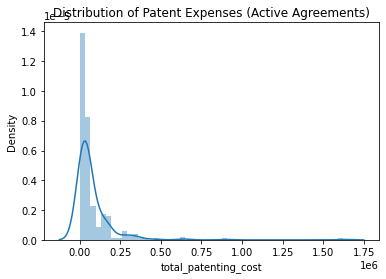

In [156]:
sns.distplot(df_pat_cost["total_patenting_cost"]).set(title='Distribution of Patent Expenses (Active Agreements)')

### Calculate average cost to patent an invention (after removing outliers)

In [157]:
mean = df_pat_cost.total_patenting_cost.mean() 
std = df_pat_cost.total_patenting_cost.std()
value = df_pat_cost.total_patenting_cost

outliers = (value-mean).abs() > 2*std
df_pat_cost.total_patenting_cost.mask(outliers, other=mean, inplace=True)

# Get average cost of patenting 
avg_cost = df_pat_cost.total_patenting_cost.mean()
print('Average cost to get invention patented:', df_pat_cost.total_patenting_cost.mean())

Average cost to get invention patented: 57721.64437000805


[Text(0.5, 1.0, 'Distribution of Patent Expenses (Active Agreements)')]

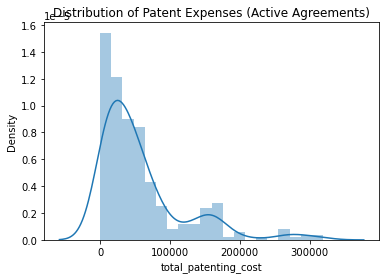

In [158]:
sns.distplot(df_pat_cost["total_patenting_cost"]).set(title='Distribution of Patent Expenses (Active Agreements)')

In [159]:
df_pat_cost.loc[26:].describe()

,Unnamed: 0,Number_of_Parties,Agreement_Term,expense_amount,party_amount_due,total_patenting_cost
count,295.000000,295.000000,287.000000,2.950000e+02,295.000000,295.000000
mean,2708.308475,1.216949,1.224739,6.913885e+04,3937.021119,56910.782163
std,933.945214,0.670352,2.823945,1.194898e+05,21470.445174,60015.548197
min,402.000000,1.000000,-1.000000,0.000000e+00,0.000000,0.000000
25%,2179.000000,1.000000,-1.000000,1.731028e+04,0.000000,17310.285000
50%,3150.000000,1.000000,0.000000,3.760409e+04,0.000000,40222.790000
75%,3387.500000,1.000000,3.000000,6.657300e+04,0.000000,67868.860000
max,3772.000000,7.000000,15.000000,1.542336e+06,293052.820000,312287.850000


### Calculate median number of patents in patent family 

In [160]:
median = pat_2012.Patents_in_Tech.median() 
std = pat_2012.Patents_in_Tech.std()
value = pat_2012.Patents_in_Tech

outliers = (value-median).abs() > 2*std
pat_2012.Patents_in_Tech.mask(outliers, other=median,  inplace=True)

# Get average number of patents in tech family for cost purposes
med_num_pats=pat_2012.Patents_in_Tech.median()
print('Median number of patents per technology:', pat_2012.Patents_in_Tech.median())

Median number of patents per technology: 8.0


### Calculate annual cost savings based on modeling results 

#### True Negatives: 100

#### Flase Positives: 10

In [162]:
print('Median number of patents per technology:', med_num_pats)
print('Average cost to get technology patented:', avg_cost)
cost_per_pat=avg_cost/med_num_pats
print('Cost per patent:', avg_cost/med_num_pats)

Median number of patents per technology: 8.0
Average cost to get technology patented: 57721.64437000805
Cost per patent: 7215.205546251006


### Incorporation of patent modeling can reduce annual patenting costs by ~65,000 USD

In [166]:
print("Annual Savings:", round((cost_per_pat*100-cost_per_pat*10)/10))

Annual Savings: 64937


# Get average number of patents in each technology 

In [6]:
ten = (102*(37959.85/8)) - (8*(37959.85/8))

ten /10

44602.823749999996

### Extract Non-Compliant records and send to Polsky Center for Analysis

In [148]:
df_pat_cost.to_csv('patent_cost.csv')